In [233]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [234]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)
#f_names = wnv_train.columns[2:]

In [235]:
# convert list of labels to binary class matrix
labels = wnv_train.WnvPresent.values.astype('int')
yr_train = labels
wnv_train.drop('WnvPresent', axis=1, inplace=True)
f_names = wnv_train.columns

In [236]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.values).astype('float64')
Xr_test = (wnv_test.values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train)

In [237]:
# parameters
n_neighbors = 30
n_components = 65
n_estimators = 5000
n_jobs = 3
p_level = 0.3

In [238]:
#clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf = ExtraTreesClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
#clf.fit(X_train, y_train)
clf.fit(Xn_train, yr_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
proba = clf.predict_proba(X_test)
expected = y_test

In [239]:
# accuracy
matches = (predicted == expected)
print matches.sum() / float(len(matches))

# f1 score

print classification_report(expected, predicted)

# confusion matrix
print confusion_matrix(expected, predicted)

# auc
print roc_auc_score(expected, proba[:,1])

0.982108869433
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2498
          1       0.96      0.67      0.79       129

avg / total       0.98      0.98      0.98      2627

[[2494    4]
 [  43   86]]
0.995084439645


Area under the ROC curve : 0.995084


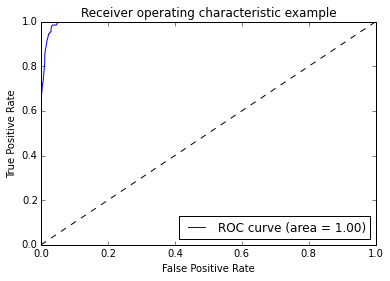

In [240]:
#print np.count_nonzero(predicted == 1)
#print np.count_nonzero(y_test)
#np.max(proba[:,1])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(expected, proba[:,1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [241]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(f_names)):
#for f in range(15):
    print("%d. %s (%f)" % (f + 1, f_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Longitude (0.281256)
2. Elevation (0.267351)
3. Latitude (0.267025)
4. CULEX PIPIENS/RESTUANS (0.022699)
5. CULEX PIPIENS (0.022330)
6. CULEX RESTUANS (0.014651)
7. CULEX TERRITANS (0.002363)
8. Sunrise (0.001485)
9. Sunset (0.001243)
10. DayOfYear (0.001237)
11. StnPressure_1_d19 (0.001203)
12. USGS04087440_d11 (0.001006)
13. USGS04087440_d13 (0.000948)
14. WetBulb_2_d17 (0.000882)
15. WetBulb_1_d19 (0.000872)
16. WetBulb_1_d18 (0.000870)
17. USGS04087440_d10 (0.000867)
18. CULEX SALINARIUS (0.000817)
19. USGS04087440_d7 (0.000768)
20. USGS04087440_d12 (0.000747)
21. USGS04087440_d9 (0.000740)
22. USGS04087440_d14 (0.000721)
23. USGS04087440_d8 (0.000715)
24. USGS04087440_d2 (0.000699)
25. Cool_1_d20 (0.000692)
26. USGS04087440_d3 (0.000661)
27. DewPoint_1_d1 (0.000653)
28. Cool_2_d20 (0.000632)
29. USGS04087440_d20 (0.000616)
30. USGS04087440_d4 (0.000615)
31. USGS04087440_d6 (0.000611)
32. USGS04087440_d15 (0.000583)
33. Cool_1_d19 (0.000569)
34. USGS04087440_d5 

In [242]:
proba = clf.predict_proba(Xn_test)
print np.max(proba[:,1])

0.34506196337


In [243]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba[:,1], "../working/sklearn_test_" + st + ".csv")